In [9]:
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import pandas as pd
import cv2
import numpy as np
import albumentations as aug
import streamlit as st
import warnings
warnings.filterwarnings('ignore')

In [10]:
WIDTH = 256
HEIGHT = 256

In [11]:
#Data model

class ImageSegmentationDataset(Dataset):

    def __init__(self, root_dir, feature_extractor, transforms=None, train=True):

        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train
        self.transforms = transforms

        sub_path = "train" if self.train else "valid"
        self.img_dir = os.path.join(self.root_dir, sub_path, "Images")
        self.ann_dir = os.path.join(self.root_dir, sub_path, "Labels")
        
        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
            image_file_names.extend(files)
        self.images = sorted(image_file_names)
        
        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "null"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):        
        image = cv2.imread(os.path.join(self.img_dir, self.images[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        dim = (WIDTH, HEIGHT)
        # resize image
        image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
        
        segmentation_map = cv2.imread(os.path.join(self.ann_dir, self.annotations[idx]))
        segmentation_map = cv2.cvtColor(segmentation_map, cv2.COLOR_BGR2GRAY)
        segmentation_map = cv2.resize(segmentation_map, dim, interpolation = cv2.INTER_AREA)

        if self.transforms is not None:
            augmented = self.transforms(image=image, mask=segmentation_map)
            encoded_inputs = self.feature_extractor(augmented['image'], augmented['mask'], return_tensors="pt")
        else:
            encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_() 

        return encoded_inputs
     


In [12]:

transform = aug.Compose([
    aug.Flip(p=0.5)
])

root_dir = 'SegTMS/'
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)

train_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=transform)
valid_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=None, train=False)
     
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))    


Number of training examples: 200
Number of validation examples: 69


In [13]:
#Data info
encoded_inputs = train_dataset[0]
encoded_inputs["pixel_values"].shape  
encoded_inputs["labels"].shape
encoded_inputs["labels"]
encoded_inputs["labels"].squeeze().unique()   
mask = encoded_inputs["labels"].numpy()  
image = encoded_inputs["pixel_values"].numpy()

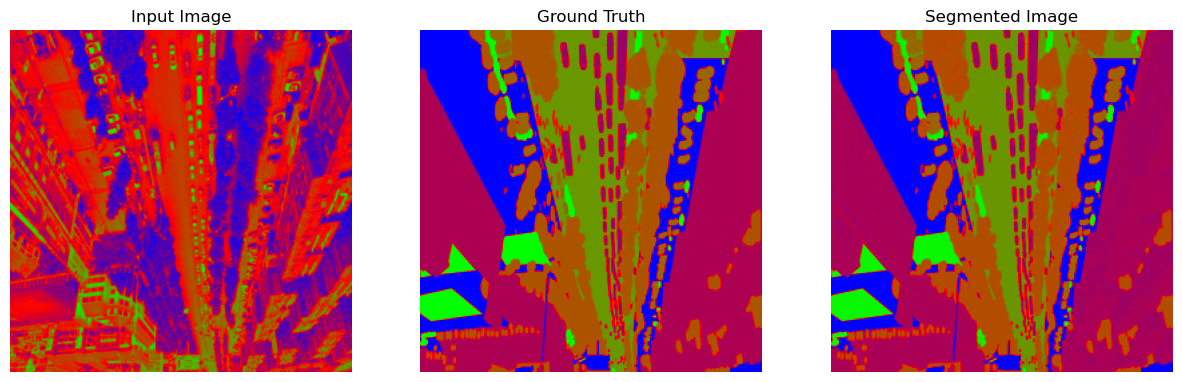

In [14]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 3, figsize=(15,15)) 
for _ in range(5):
    ax[0].axis('off')
    ax[0].set_title('Input Image') 
    ax[0].imshow(image[-1], cmap='brg')
    ax[1].axis('off')
    ax[1].set_title('Ground Truth') 
    ax[1].imshow(mask, cmap='brg')
    
    ax[2].axis('off')
    ax[2].set_title('Segmented Image')
    imgs = np.array(image[-1]) * 0.5 + mask * 0.5
    imgs = imgs.astype(np.uint8)   
    ax[2].imshow(imgs, cmap='brg')
    plt.show()


In [37]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)    

batch = next(iter(train_dataloader))    

for k,v in batch.items():
    print(k, v.shape)    
    
print(batch["labels"].shape)

print(batch["pixel_values"].shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])
torch.Size([2, 512, 512])
torch.Size([2, 3, 512, 512])


In [38]:
pixel_values = batch["pixel_values"]
labels = batch["labels"]
